##### Students :
- Adrien Mainka 20130281
- Abdelmoneim AlKhalil

To be able to run this notebook, the data files needs to be unzipped and store in `./data/`

## Vocabulary Size

To measure the vocabulary size, we use a simple naive space tokenizer :<br> 
`tr ' ' '\n'` or `str.split()` <br>
And we removed all the capital letters.

In [1]:
import time
import kenlm
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def countInFile(filename):
    counter = Counter()
    f = open(filename)
    line = f.readline()
    while line:
        for token in line.lower().split():
            counter[token] += 1
        line = f.readline()
    f.close()
    return counter

### train.en

In [2]:
counters = dict()

In [3]:
# !cat data/train.en | tr ' ' '\n' | sort | uniq | wc -w
# 859973
start_time = time.time()
dataset_name = "train.en"
directory = "./data/"
counters[dataset_name] = countInFile(directory + dataset_name)
print("vocab size = {:,}\t elapsed time = {:.2f} s".format(len(counters[dataset_name]), time.time() - start_time))

vocab size = 732,761	 elapsed time = 40.78 s


### train.fr

In [4]:
# !cat data/train.fr | tr ' ' '\n' | sort | uniq | wc -w
# TOO SLOW
start_time = time.time()
dataset_name = "train.fr"
directory = "./data/"
counters[dataset_name] = countInFile(directory + dataset_name)
print("vocab size = {:,}\t elapsed time = {:.2f} s".format(len(counters[dataset_name]), time.time() - start_time))

vocab size = 2,879,802	 elapsed time = 547.03 s


### train.de

In [5]:
# !cat data/train.de | tr ' ' '\n' | sort | uniq | wc -w
start_time = time.time()
dataset_name = "train.de"
directory = "./data/"
counters[dataset_name] = countInFile(directory + dataset_name)
print("vocab size = {:,}\t elapsed time = {:.2f} s".format(len(counters[dataset_name]), time.time() - start_time))

vocab size = 1,562,794	 elapsed time = 44.28 s


## Number of words seen at least 100 times
### train.en

In [9]:
# !cat data/train.en | tr ' ' '\n' | sort | uniq -c | sort -k1 -nr | awk '$1 > 99' | wc -l
dataset_name = "train.en"
print("Number of words seenat least 100 times : {:,}".format(len([token for token in counters[dataset_name] if counters[dataset_name][token] >= 100])))

Number of words seenat least 100 times : 26,794


## train.fr

In [10]:
# !cat data/train.fr | tr ' ' '\n' | sort | uniq -c | sort -k1 -nr | awk '$1 > 99' | wc -l
dataset_name = "train.de"
print("Number of words seenat least 100 times : {:,}".format(len([token for token in counters[dataset_name] if counters[dataset_name][token] >= 100])))

Number of words seenat least 100 times : 40,318


### train.de

In [12]:
# !cat data/train.de | tr ' ' '\n' | sort | uniq -c | sort -k1 -nr | awk '$1 > 99' | wc -l
print("Number of words seenat least 100 times : {:,}".format(len([token for token in counters[dataset_name] if counters[dataset_name][token] >= 100])))

Number of words seenat least 100 times : 40,318


## Number of words seen in test but not in train
### train.en

In [16]:
dataset_name = "test.en"
directory = "./data/"
counters[dataset_name] = countInFile(directory + dataset_name)
print("Number of words seen in test but not in train: {:,}".format(len([word for word in counters[dataset_name] if not word in counters["train.en"]])))

Number of words seen in test but not in train: 389


### train.fr

In [17]:
dataset_name = "test.fr"
directory = "./data/"
counters[dataset_name] = countInFile(directory + dataset_name)
print("Number of words seen in test but not in train: {:,}".format(len([word for word in counters[dataset_name] if not word in counters["train.fr"]])))

Number of words seen in test but not in train: 122


### train.de

In [18]:
counters["test_de"] = countInFile("data/test.de")
print("Number of words seen in test but not in train: {:,}".format(len([word for word in counters[dataset_name] if not word in counters["train.de"]])))

Number of words seen in test but not in train: 2,824


## Number of words per number of occurence

There are 390671 hapax legomena in train.en


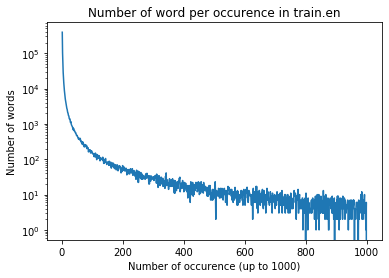

In [19]:
occurs_max = 1000
dataset_name = "train.en"
y = np.zeros(occurs_max)
for word in counters[dataset_name]:
    if counters[dataset_name][word]<occurs_max:
        y[counters[dataset_name][word]-1] += 1
plt.plot(np.arange(1,occurs_max+1), y)
plt.yscale("log")
plt.xlabel("Number of occurence (up to {})".format(occurs_max))
plt.ylabel("Number of words")
plt.title("Number of word per occurence in {}".format(dataset_name))
print("There are {} hapax legomena in {}".format(int(y[0]), dataset_name))

There are 1464203 hapax legomena in train.fr


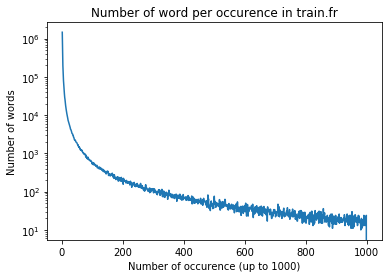

In [20]:
occurs_max = 1000
dataset_name = "train.fr"
y = np.zeros(occurs_max)
for word in counters[dataset_name]:
    if counters[dataset_name][word]<occurs_max:
        y[counters[dataset_name][word]-1] += 1
plt.plot(np.arange(1,occurs_max+1), y)
plt.yscale("log")
plt.xlabel("Number of occurence (up to {})".format(occurs_max))
plt.ylabel("Number of words")
plt.title("Number of word per occurence in {}".format(dataset_name))
print("There are {} hapax legomena in {}".format(int(y[0]), dataset_name))

There are 864889 hapax legomena in train.de


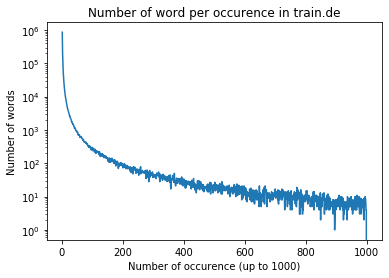

In [21]:
occurs_max = 1000
dataset_name = "train.de"
y = np.zeros(occurs_max)
for word in counters[dataset_name]:
    if counters[dataset_name][word]<occurs_max:
        y[counters[dataset_name][word]-1] += 1
plt.plot(np.arange(1,occurs_max+1), y)
plt.yscale("log")
plt.xlabel("Number of occurence (up to {})".format(occurs_max))
plt.ylabel("Number of words")
plt.title("Number of word per occurence in {}".format(dataset_name))
print("There are {} hapax legomena in {}".format(int(y[0]), dataset_name))

{{occurs_max}}

## Create a language model

We have trained five different models with orders from 2 to 5 using a preprocessing function that only removes uppercase characters.

In [3]:
def evaluate_model(model, filename):
    """ Return the mean perplexity of model on test dataset given its filename
    """
    f = open(filename)
    line = f.readline()
    ppl = []
    while line:
        ppl.append(model.perplexity(line.lower()))
        line = f.readline()
    f.close()
    return np.mean(ppl)

def evaluate_models(models, filename):
    """ Return the mean perplexity a list of models on test dataset given its filename
    """
    ppl = [ [] for _ in models]
    f = open(filename)
    line = f.readline()
    while line:
        for i, model in enumerate(models):
            ppl[i].append(model.perplexity(line.lower()))
        line = f.readline()
    f.close()
    return np.mean(ppl,1)

In [42]:
models = [ kenlm.Model("./arpa/train.en.n{}.arpa".format(i)) for i in range(2,6) ]

In [41]:
kenlm.Model("./arpa/train.en.n2.arpa")

<Model from b'train.en.n2.arpa'>

In [32]:
evaluate_model(model, "data/test.en")

173.9097266687331

In [34]:
a = np.mean(np.arange(100).reshape(10,10),1)

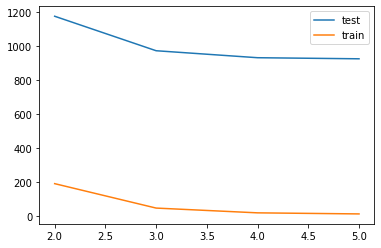

In [47]:
plt.plot(np.arange(2,6), evaluate_models(models, "./data/test.en"), label="test")
plt.plot(np.arange(2,6), evaluate_models(models, "./data/train.en"), label="train")
plt.legend()

In order to improve the model quality, we will enhance the preprocessing by replacing all the words seen less 10 times with the token `UNK`

In [62]:
def preprocess(filename, destination, threshold, counter=None, replacement="UNK"):
    """ This function preprocesses a dataset as a file by replacing all the words seen less than threshold times by replacement.
        If no counter is provided, the function will count the words itself.
    """
    if not counter:
        counter = countInFile(filename)
    f1 = open(filename, "r")
    f2 = open(destination, "w")
    line = f1.readline()
    while line:
        f2.write(' '.join([ word if counter[word] > threshold else replacement for word in line.lower().split() ]) + '\n')
        line = f1.readline()
    f1.close()
    f2.close()

In [63]:
preprocess("data/train.en", "preprocessed/train.en", 10, counters["train.en"])

In [2]:
models2 = [ kenlm.Model("./arpa/train2.en.n{}.arpa".format(i)) for i in range(2,6) ]

Text(0.5, 1.0, 'Perplexity ')

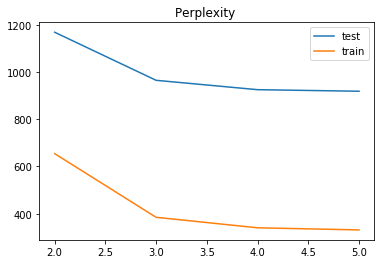

In [5]:
plt.plot(np.arange(2,6), evaluate_models(models2, "./data/test.en"), label="test")
plt.plot(np.arange(2,6), evaluate_models(models2, "./preprocessed/train.en"), label="train")
plt.legend()
plt.title("Perplexity ")